In [1]:
from src.preprocessing import build_preprocess
from src.utils import load_data
from src.config import *
from src.models import train_model
from src.preprocessing import initial_prep
from sklearn.model_selection import train_test_split
import numpy as np
from src.evaluation import classification_metrics_full
from sklearn.svm import LinearSVC


In [2]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.base import clone
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

from src.preprocessing import build_preprocess


def build_stacking_model(
    base_clf,
    k_values,
    numeric_cols,
    include_full=True,
    big=True,
    scale_numeric=True,
    stack_cv=5,
    final_estimator=None,
    n_jobs=-1,
):
    """
    Creates a StackingClassifier with base learners:
      - same base_clf with different k on text chi2 selection
      - optionally an additional "full features" base learner
    """
    if final_estimator is None:
        final_estimator = LogisticRegression(max_iter=5000, solver="lbfgs")

    estimators = []

    # k-based base learners
    for k in k_values:
        text_prep = build_preprocess("chi2_test", big=big, svd=False)
        extras_prep = ColumnTransformer(
            transformers=[
                ("source", OneHotEncoder(handle_unknown="ignore"), ["source"]),
                ("num", StandardScaler() if scale_numeric else "passthrough", numeric_cols),
            ],
            remainder="drop"
        )

        text_branch = Pipeline([
            ("prep", text_prep),
            ("fs", SelectKBest(chi2, k=k)),
        ])

        features = FeatureUnion([
            ("text", text_branch),
            ("extras", extras_prep),
        ])
        est = Pipeline([
            ("features", features),
            ("clf", clone(base_clf)),
        ])
        estimators.append((f"base_k{k}", est))

    # full base learner (no chi2 selection)
    if include_full:
        features_full = build_preprocess("linear_svm", big=big, svd=False)
        est_full = Pipeline([
            ("features", features_full),
            ("clf", clone(base_clf)),
        ])
        estimators.append(("base_full", est_full))

    # Important: for stacking, base estimators should expose predict_proba OR decision_function
    # If your base_clf is LinearSVC (no proba), either:
    #   - wrap base_clf with CalibratedClassifierCV outside and pass that as base_clf, OR
    #   - set stack_method="decision_function" below (works if base supports it)
    stack = StackingClassifier(
        estimators=estimators,
        final_estimator=final_estimator,
        cv=stack_cv,                 # OOF preds for meta-learner
        stack_method="predict_proba",
        n_jobs=n_jobs,
        passthrough=False,
    )
    return stack


In [7]:
def refinement(X_train, X_test, y_train, y_test, y_pred, model_name, hyperparams, big):
    # k_values = [5000, 70000, 100000]
    # params = {'C': 0.04773295631615594,
    # 'max_iter': 5000,
    # 'dual': True,
    # 'class_weight': {0: 1.0, 1: 3, 2: 2},
    # # 'class_weight': "balanced",
    # 'random_state': 1000}
    # from sklearn.calibration import CalibratedClassifierCV
    # base_clf = CalibratedClassifierCV(
    #     LinearSVC(**params),
    #     cv=2,
    #     method="sigmoid",
    # )

    # numeric_cols = [
    #     "page_rank",
    #     "timestamp_missing",
    #     "year",
    #     "len_article",
    #     "len_title",
    #     "dayofweek",
    #     "month",
    #     "hour"
    # ]
    # stack = build_stacking_model(base_clf, k_values, numeric_cols)


    mask_train = y_train.isin([0,3,5])
    X_train_g = X_train.loc[mask_train]
    y_train_g = y_train.loc[mask_train]
    # y_train_g = y_train_g.map({0:0, 3:1, 5:2})


    mask_test = np.isin(y_pred, [0,3,5])
    X_test_g = X_test.iloc[mask_test]      # mask numpy => iloc
    y_test_g = y_test.iloc[mask_test]

    print("unique y_train_g:", np.unique(y_train_g))

    preprocess = build_preprocess(model_name, big=big)

    X_train_prep = preprocess.fit_transform(X_train_g)
    X_test_prep = preprocess.transform(X_test_g)

    result, y_pred = train_model(model_name, hyperparams, X_train_prep, X_test_prep, y_train_g, y_test_g)

    # stack.fit(X_train_g, y_train_g)

    # pred = stack.predict(X_test_g)

    # mapping = {0: 0, 1: 3, 2: 5}
    # pred = np.vectorize(mapping.get)(pred).astype(int)

    return result, y_pred


def performance2(model_name, hyperparams, big):
    """
    Given a single model name and a dict with the params,
    it returns the performance computed on a single holdout split, only on the DEVELOPMENT dataset.
    """
    news_df = load_data(DEVELOPMENT_PATH)
    X = news_df.drop(columns=['y'])
    y = news_df['y']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)

    preprocess = build_preprocess(model_name, big=big)
    X_train_prep = preprocess.fit_transform(X_train)
    X_test_prep = preprocess.transform(X_test)
    print(X_train.shape)

    result_old, y_pred = train_model(model_name, hyperparams, X_train_prep, X_test_prep, y_train, y_test)
    print('here1')
    res_g, y_pred_g = refinement(X_train, X_test, y_train, y_test, y_pred, model_name, hyperparams, big)
    print('here2')
    
    y_pred_old = y_pred.copy()

    y_pred[np.isin(y_pred,[0,3,5])] = y_pred_g

    result = classification_metrics_full(y_test, y_pred)

    return result, result_old, res_g, y_pred, y_test.index, y_pred_old, y_pred_g

In [8]:

param = {'C': 0.04773295631615594,
  'max_iter': 5000,
  'dual': True,
  'class_weight': {0: 1.0, 1: 2.2, 2: 2.1, 3: 2.4, 4: 2.7, 5: 1.8, 6: 7.6},
  'random_state': 1000}
result, result_old, res_g, y_pred, test_idxs, y_pred_old, y_pred_g = performance2('linear_svm', param, True)

(61302, 17)
here1
unique y_train_g: [0 3 5]
here2


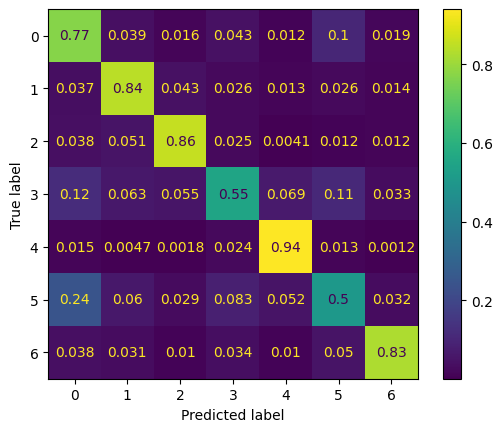

In [9]:
from src.utils import plot_cm
plot_cm(result_old['confusion_matrix'], normalize=True)

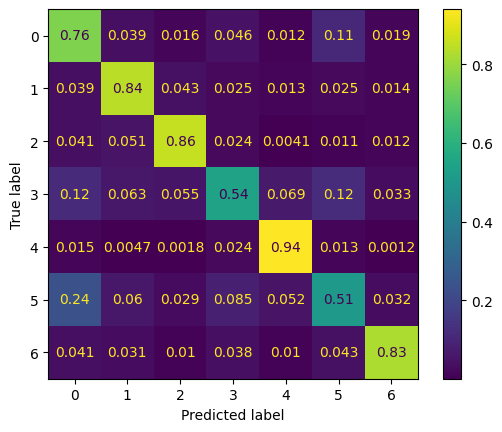

In [10]:
from src.utils import plot_cm
plot_cm(result['confusion_matrix'], normalize=True)

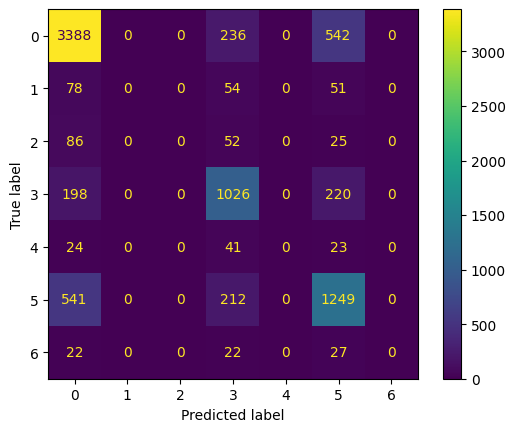

In [8]:
from src.utils import plot_cm
plot_cm(result_g['confusion_matrix'], normalize=False)

In [11]:
result

{'aggregated': {'precision_macro': 0.7200576720292469,
  'recall_macro': 0.7528795998457793,
  'f1_macro': 0.7325888376923327},
 'per_class': {'precision': array([0.77436013, 0.75108225, 0.84552476, 0.63177806, 0.81945163,
         0.5907559 , 0.62745098]),
  'recall': array([0.75735617, 0.8414161 , 0.85760369, 0.54074474, 0.94005935,
         0.50681537, 0.82616179]),
  'f1': array([0.76576377, 0.7936871 , 0.85152139, 0.58272754, 0.87562189,
         0.54557581, 0.71322437]),
  'support': array([4554, 2062, 2170, 1853, 1685, 2421,  581])},
 'confusion_matrix': array([[3449,  176,   71,  211,   53,  506,   88],
        [  80, 1735,   89,   52,   26,   51,   29],
        [  88,  110, 1861,   52,    9,   23,   27],
        [ 219,  117,  102, 1002,  128,  223,   62],
        [  25,    8,    3,   41, 1584,   22,    2],
        [ 569,  146,   69,  206,  127, 1227,   77],
        [  24,   18,    6,   22,    6,   25,  480]])}